# Enron Persons of Interest Analysis
By: Chad-Michael Renner

# Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives.

In this project, I will be building a machine learning algorythm to analyze this data and find certain persons of interest (POI). During this analysis I will be going through 6 separate steps, 7 if you count importing the data.  These steps include: 
 1. Select features
 2. Remove Outliers
 3. Create new feature(s)
 4. Try a varity of classifiers
 5. Tune classifier
 6. Algorythm and Validation

# Import and load Data

In [1]:
#!/usr/bin/python
import pprint
import matplotlib.pyplot as plt
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

/Users/crenner15/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/crenner15/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Task 1: Select what features you'll use.

In [13]:
# Explore dataset
financial_features = ['poi', 'salary', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock']
email_features = ['poi', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
data_points = len(data_dict)
poi_count = 0
non_poi_count = 0
print "Data points:\t\t", data_points
print "no of POIs:\t\t", poi_count
print "no of non POIs:\t\t", non_poi_count
print "POI ratio:\t\t", poi_count/data_points
print "Total features:\t\t", len(data_dict[data_dict.keys()[0]])
print "Financial features:\t", len(financial_features)
print "Email features:\t\t", len(email_features)
print ""

Data points:		145
no of POIs:		0
no of non POIs:		0
POI ratio:		0
Total features:		23
Financial features:	11
Email features:		6



Here I am checking the features of the data set and splitting them into two categories.  Financial_features takes in all associated financial data and email_features takes in all features associated with emails.  As you can see from the print statements, there are 146 data points (executives) in the POI data with 21 total features.  Of those features, 11 are associated with the financial features and 6 are associated with email features.

In [14]:
# check for missing values
missing_value_map = { 'bonus': {'count':0, 'poi':0}, 'deferral_payments': {'count':0, 'poi':0},
    'deferred_income': {'count':0, 'poi':0},'director_fees': {'count':0, 'poi':0},
    'exercised_stock_options': {'count':0, 'poi':0}, 'total_payments': {'count':0, 'poi':0},
    'expenses': {'count':0, 'poi':0}, 'loan_advances': {'count':0, 'poi':0},
    'long_term_incentive': {'count':0, 'poi':0}, 'restricted_stock_deferred': {'count':0, 'poi':0},
    'other': {'count':0, 'poi':0}, 'restricted_stock': {'count':0, 'poi':0},
    'total_stock_value': {'count':0, 'poi':0}, 'salary': {'count':0, 'poi':0},
    'email_address': {'count':0, 'poi':0}, 'from_messages': {'count':0, 'poi':0},
    'from_poi_to_this_person': {'count':0, 'poi':0}, 'shared_receipt_with_poi': {'count':0, 'poi':0},
    'from_this_person_to_poi': {'count':0, 'poi':0}, 'to_messages': {'count':0, 'poi':0} }

for person, features in data_dict.iteritems():
    isPoi = False
    if features['poi'] == True:
        poi_count += 1
        isPoi = True
    else:
        non_poi_count += 1
    for name, value in features.iteritems():
        if value == 'NaN':
            missing_value_map[name]['count'] += 1
            if isPoi:
                missing_value_map[name]['poi'] += 1

missing_value_map

{'bonus': {'count': 64, 'poi': 2},
 'deferral_payments': {'count': 107, 'poi': 13},
 'deferred_income': {'count': 97, 'poi': 7},
 'director_fees': {'count': 129, 'poi': 18},
 'email_address': {'count': 34, 'poi': 0},
 'exercised_stock_options': {'count': 44, 'poi': 6},
 'expenses': {'count': 51, 'poi': 0},
 'from_messages': {'count': 59, 'poi': 4},
 'from_poi_to_this_person': {'count': 59, 'poi': 4},
 'from_this_person_to_poi': {'count': 59, 'poi': 4},
 'loan_advances': {'count': 142, 'poi': 17},
 'long_term_incentive': {'count': 80, 'poi': 6},
 'other': {'count': 53, 'poi': 0},
 'restricted_stock': {'count': 36, 'poi': 1},
 'restricted_stock_deferred': {'count': 128, 'poi': 18},
 'salary': {'count': 51, 'poi': 1},
 'shared_receipt_with_poi': {'count': 59, 'poi': 4},
 'to_messages': {'count': 59, 'poi': 4},
 'total_payments': {'count': 21, 'poi': 0},
 'total_stock_value': {'count': 20, 'poi': 0}}

To check for any missing data, I checked through each of the 146 executived and counted the number of NaN values in the data and also the number of POI's with missing data for each feature.

In [15]:
#Find features with more than 50% of missing values
significant_missing_values = []
significant_poi_values = []
print "{:<25} {:<20} {:<10}".format('Feature','missing','poi')
for feature, values in missing_value_map.iteritems():
    missing_ratio = values['count']/data_points
    if missing_ratio > 0.5:
        significant_missing_values.append(feature)
    poi_ratio = values['poi']/poi_count
    if poi_ratio > 0.5:
        significant_poi_values.append(feature)
    print "{:<25} {:<20} {:<10}".format(feature, values['count'], values['poi'])

print ""
print "Features with >50% missing values:", significant_missing_values
print ""
print "Features with pois with >50% missing values:", significant_poi_values
print ""

Feature                   missing              poi       
salary                    51                   1         
shared_receipt_with_poi   59                   4         
deferral_payments         107                  13        
total_payments            21                   0         
loan_advances             142                  17        
bonus                     64                   2         
email_address             34                   0         
restricted_stock_deferred 128                  18        
total_stock_value         20                   0         
expenses                  51                   0         
from_poi_to_this_person   59                   4         
exercised_stock_options   44                   6         
from_messages             59                   4         
other                     53                   0         
to_messages               59                   4         
from_this_person_to_poi   59                   4         
deferred_incom

Features that have a poi with greater than 50% missing values is restricted stock deffered and director fees.  These missing values can mostly be attributed to the fact that not every one of the directors received these financial features for their work.

# Task 2: Remove outliers

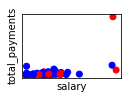

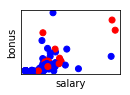

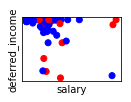

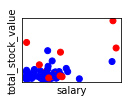

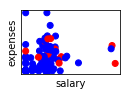

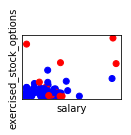

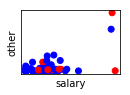

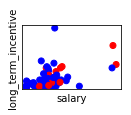

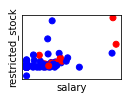

In [16]:
financial_outliers = featureFormat(data_dict, financial_features)
email_outliers = featureFormat(data_dict, email_features)

def outlier_visualization(data, a, b, a_name, b_name, pos):
    plt.subplot(3,3,pos)
    f1 = []
    f2 = []
    y = []
    for point in data:
        f1.append(point[a])
        f2.append(point[b])
        c = 'red' if point[0]==True else 'blue'
        y.append(c)
    plt.scatter(f1, f2, c=y)

    frame = plt.gca()
    frame.axes.get_xaxis().set_ticks([])
    frame.axes.get_yaxis().set_ticks([])
    plt.xlabel(a_name)
    plt.ylabel(b_name)
    plt.show()


def visualize_outliers():
    start = 1
    for i in range(2, len(financial_features)):
        outlier_visualization(financial_outliers, 1, i, 'salary', financial_features[i], start)
        start += 1
    start = 10

    
visualize_outliers()

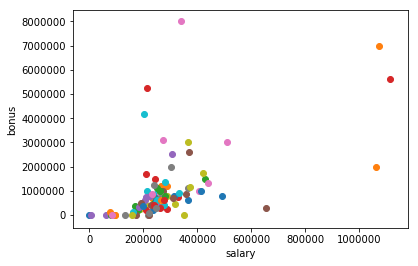

In [17]:
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

To highlight one example for the oulier removal, I plotted this to show the before of salary and bonus and below will remove the outliers.

In [18]:
### remove any outliers before proceeding further
features = ["salary", "bonus"]
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))

outliers_final = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])

### print top 4 salaries
print outliers_final

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


When I check for outliers, I see there are a number of outliers.  In this example, I removed the outliers for total salary and bonus. As this is not sensible information for our analysis I remove it. Two more outliers (SKILLING JEFFREY and LAY KENNETH) I keep in dataset as these values are real and actually is a sign that these two managers are involved in the fraud. Now dataset look like this:

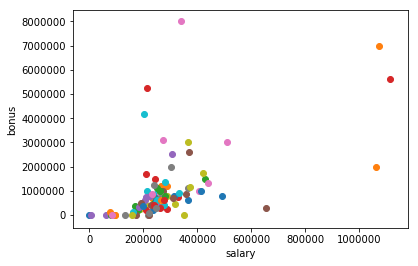

In [19]:
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

# Task 3: Create new feature(s)

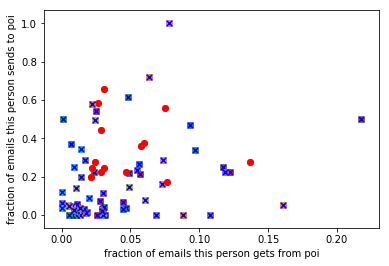

In [20]:
### new features are: fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"]=fraction_from_poi_email[count]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[count]
    count +=1

    
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"]    
    ### store to my_dataset for easy export below
data_dict.pop('TOTAL', 0)
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", label="POI")
    else:
        plt.scatter(from_poi, to_poi, color="b", marker="x", label="Non-POI")

plt.xlabel("fraction of emails this person gets from poi")
plt.ylabel("fraction of emails this person sends to poi")
plt.show()

In order to find the most effective features for classification, feature selection using “Decision Tree” was deployed to rank the features. Selection features was half manual iterative process. First I put all the possible features into features_list and then started deleting them one by one using score value and human intuition.

# Task 4: Try a varity of classifiers

In [21]:
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(
    features, labels, test_size=0.1, random_state=42)




from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'accuracy', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"



importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print 'Feature Ranking: '
for i in range(16):
    print "{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]])

accuracy 0.8
Decision tree algorithm time: 0.003 s
Feature Ranking: 
1 feature salary (0.211707133446)
2 feature bonus (0.174317879326)
3 feature fraction_from_poi_email (0.14622972935)
4 feature fraction_to_poi_email (0.118337314859)
5 feature deferral_payments (0.0955181169023)
6 feature total_payments (0.0879795396419)
7 feature loan_advances (0.0747826086957)
8 feature restricted_stock_deferred (0.0534161490683)
9 feature deferred_income (0.0377115287109)
10 feature total_stock_value (0.0)
11 feature expenses (0.0)
12 feature exercised_stock_options (0.0)
13 feature long_term_incentive (0.0)
14 feature shared_receipt_with_poi (0.0)
15 feature restricted_stock (0.0)
16 feature director_fees (0.0)


Finally I picked 10 features which are: 
<br>
* ["salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email", 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value']

Accuracy for this feature set is around 0.8.<br>
<br>
But with these features my precision and recall were too low (less than 0.3) so I had to change my strategy and manually pick features which gave me precision and recall values over 0.3. In this dataset I cannot use accuracy for evaluating my algorithm because there a few POI’s in dataset and the best evaluator are precision and recall. There were only 18 examples of POIs in the dataset. There were 35 people who were POIs in “real life”, but for various reasons, half of those are not present in this dataset.
Finally I picked the following features: ["fraction_from_poi_email", "fraction_to_poi_email", “shared_receipt_with_poi”]

# Task 5: Tune your classifier to achieve better than .3 precision

In [25]:
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", "shared_receipt_with_poi"]

### try Naive Bayes for prediction
t0 = time()

clf = DecisionTreeClassifier(min_samples_split=6)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print accuracy

print "algorithm time:", round(time()-t0, 3), "s"

0.928571428571
algorithm time: 0.003 s


After playing around with the min_samples_split, I found the highest accuracy is acheived around 6

 # Task 6: Final Algorithm and Dump your classifier, dataset, and features_list

In [33]:
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", 'shared_receipt_with_poi']


### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)


### machine learning goes here!
### please name your classifier clf for easy export below

### deploying feature selection
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(
    features, labels, test_size=0.4, random_state=42)

### use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    #make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
print 'accuracy before tuning ', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"


### use manual tuning parameter min_samples_split
t0 = time()
clf = DecisionTreeClassifier(min_samples_split=6)
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("done in %0.3fs" % (time() - t0))

acc=accuracy_score(labels_test, pred)

print "Validating algorithm:"
print "accuracy after tuning = ", acc

# function for calculation ratio of true positives
# out of all positives (true + false)
print 'precision = ', precision_score(labels_test,pred)

# function for calculation ratio of true positives
# out of true positives and false negatives
print 'recall = ', recall_score(labels_test,pred)


### dump your classifier, dataset and features_list so
### anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )

accuracy before tuning  0.892857142857
Decision tree algorithm time: 0.002 s
done in 0.001s
Validating algorithm:
accuracy after tuning =  0.928571428571
precision =  0.666666666667
recall =  0.666666666667


# Conclusion

The precision can be interpreted as the likelihood that a person who is identified as a POI is actually a true POI; the fact that this is 0.68 means that using this identifier to flag POI’s would result in 32% of the positive flags being false alarms. Recall measures how likely it is that identifier will flag a POI in the test set. 68% of the time it would catch that person, and 32% of the time it wouldn’t.
These numbers are quite good but we still can improve the strategy. One of the possible paths to improvement is digging in to the emails data more. The email features in the starter dataset were aggregated over all the messages for a given person. By digging into the text of each individual’s messages, it’s possible that more detailed patterns (say, messages to/from a specific address, rather than just messages to/from any POI address, or the usage of specific vocabulary terms) might emerge. Since we live in a world in which more POI finance data might not be easy to find, the next realistic thing to try might be to extract more data from the emails.